In [1]:
from langchain.llms import AzureOpenAI
import openai
from dotenv import load_dotenv
import os
from IPython.display import display, HTML
import json
import sklearn

In [6]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") 
OPENAI_DEPLOYMENT_ENDPOINT = os.getenv("OPENAI_DEPLOYMENT_ENDPOINT")
OPENAI_DEPLOYMENT_NAME = os.getenv("OPENAI_DEPLOYMENT_NAME")
OPENAI_MODEL_NAME = os.getenv("OPENAI_MODEL_NAME")
OPENAI_DEPLOYMENT_VERSION = os.getenv("OPENAI_DEPLOYMENT_VERSION")

OPENAI_EMBEDDING_DEPLOYMENT_NAME = os.getenv("OPENAI_EMBEDDING_DEPLOYMENT_NAME")
OPENAI_EMBEDDING_MODEL_NAME = os.getenv("OPENAI_EMBEDDING_MODEL_NAME")

OPENAI_DAVINCI_DEPLOYMENT_NAME = os.getenv("OPENAI_DAVINCI_DEPLOYMENT_NAME")
OPENAI_DAVINCI_MODEL_NAME = os.getenv("OPENAI_DAVINCI_MODEL_NAME")

# Configure OpenAI API
openai.api_type = "azure"
openai.api_version = OPENAI_DEPLOYMENT_VERSION
openai.api_base = OPENAI_DEPLOYMENT_ENDPOINT
openai.api_key = OPENAI_API_KEY

### **Model Initialization**

In [7]:
def init_llm(model=OPENAI_MODEL_NAME,
             deployment_name=OPENAI_DEPLOYMENT_NAME, 
             temperature=0,
             max_tokens=3000,
             stop="<|im_end|>", 
             ):
    
    llm = AzureOpenAI(deployment_name=deployment_name,  
                  model=model,
                  temperature=temperature,) 
    return llm

In [8]:
#Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain.chat_models import ChatOpenAI

# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

In [9]:
llm=init_llm()
embeddings = OpenAIEmbeddings(model=OPENAI_EMBEDDING_DEPLOYMENT_NAME)

In [37]:
from langchain.document_loaders import PyPDFLoader

large_pdf_path ="./data/Large_language_model.pdf"
loader = PyPDFLoader(large_pdf_path)

text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=10000, chunk_overlap=3000)
pages = loader.load_and_split(text_splitter=text_splitter)

document_vectors=[]
for page in pages:
    document_vectors.append(embeddings.embed_documents([page.page_content], chunk_size=1)[0] )     

Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Requests to the Embeddings_Create Operation under Azure OpenAI API version 2022-12-01 have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 10 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Requests to the Embeddings_Create Operation under Azure OpenAI API version 2022-12-01 have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 6 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit..
Retrying langchain.embeddings.openai.embed_with_retry.<locals>._embed_with_retry in 4.0 seconds as it raised RateLimitError: Requests to the Embeddings_C

In [44]:
print("Document vectors shape: ", np.array(document_vectors).shape)

Document vectors shape:  (16, 1536)


In [45]:
print(document_vectors[0])

[-0.013042767183938769, 0.019140244881889947, 0.011462442270847537, -0.0190588547416222, -0.008295010553857791, -0.010126287778559544, 0.0005481116094502884, 0.02030683627151262, -0.021907507788348237, -0.05293071128668411, 0.0067079028186367295, 0.034590802163211976, -0.0297616563241858, 0.009739684612287747, 0.007589629182983561, 0.005568440854888275, 0.02189394400673368, 0.010804539257898283, 0.015057173155565502, -0.015206387791841337, -0.005361574558815268, -0.00513436026201405, -0.017905827133614088, -0.020266141201378745, -0.01212034621511934, 0.008010145062920677, 0.021120737674190086, -0.034617933451731295, -0.00977359779161434, -0.0006430667536934398, 0.0027333515897767957, 0.01224243142552096, -0.028812104066847054, 0.008871523426539298, -0.002889349513843735, -0.0016710409681262195, 0.030358516731934244, 0.0036998595054562886, 0.03280021907732155, -0.026356836077200095, 0.024891813552380654, 0.03757510606459929, 0.00959725186681919, -0.009305604485074797, -0.001634585045408

In [46]:
num_clusters = 8

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(document_vectors)

In [47]:
kmeans.labels_

array([3, 3, 6, 5, 5, 0, 2, 4, 4, 4, 7, 1, 1, 1, 1, 1], dtype=int32)

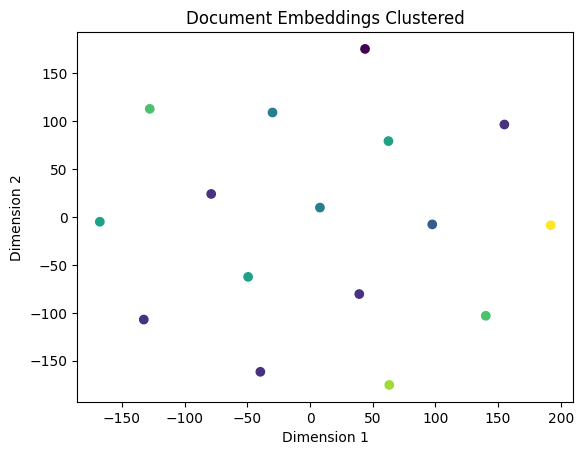

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Taking out the warnings
import warnings
from warnings import simplefilter

num_samples = len(document_vectors)

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=num_samples-1)
reduced_data_tsne = tsne.fit_transform(np.array(document_vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Document Embeddings Clustered')
plt.show()

In [49]:
# Find the closest embeddings to the centroids

# Create an empty list for closest points
closest_indices = []

# Loop through the number of clusters 
for i in range(num_clusters):
    
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(document_vectors - kmeans.cluster_centers_[i], axis=1)
    
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [50]:
selected_indices = sorted(closest_indices)
selected_indices

[1, 2, 3, 5, 6, 8, 10, 14]

In [51]:
print(len(pages))
#for selectedidx in selected_indices:
#   print (pages[selectedidx].page_content)


selected_pages = [pages[pageidx] for pageidx in selected_indices]


16


In [52]:
#create summarization chain
summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce',verbose=False )

In [53]:
#run summarization chain on selected pages
sum = summary_chain.run(selected_pages)

display(HTML(sum))

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Requests to the Completions_Create Operation under Azure OpenAI API version 2022-12-01 have exceeded token rate limit of your current OpenAI S0 pricing tier. Please retry after 54 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Requests to the Completions_Create Operation under Azure OpenAI API version 2022-12-01 have exceeded token rate limit of your current OpenAI S0 pricing tier. Please retry after 50 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Requests to

RateLimitError: Requests to the Completions_Create Operation under Azure OpenAI API version 2022-12-01 have exceeded token rate limit of your current OpenAI S0 pricing tier. Please retry after 23 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.